## Correlation between news and stock movement

### Load All Datasets

In [ ]:
import pandas as pd

# Load news data 
news_df = pd.read_csv('C:/nova_financial_insights/datasets/raw_analyst_ratings.csv', parse_dates=['date'])

# Load all stock datasets
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
stocks = {ticker: pd.read_csv(f'{ticker}_historical_data.csv', parse_dates=['Date'], index_col='Date') 
          for ticker in tickers}

In [4]:
print(len(news_df))

1407328


### Prepare Date 

In [3]:
from dateutil import parser

def try_parse_date(x):
    try:
        return parser.parse(str(x), fuzzy=True).date()  # Keep only date part
    except Exception:
        return pd.NaT

# Apply to the whole column (slow but very flexible)
news_df['date'] = news_df['date'].apply(try_parse_date)

# Drop only truly unfixable ones
news_df = news_df.dropna(subset=['date'])


In [ ]:
for ticker in stocks:
    df = stocks[ticker]
    df.index = pd.to_datetime(df.index).map(lambda x: x.date())  # convert index to date only
    stocks[ticker] = df

### Sentiment Analysis

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Add sentiment scores (VADER's compound score ranges from -1 to 1)
news_df['sentiment'] = news_df['headline'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

# Classify sentiment
news_df['sentiment_label'] = pd.cut(
    news_df['sentiment'],
    bins=[-1, -0.05, 0.05, 1],
    labels=['negative', 'neutral', 'positive']
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Align Dates

In [13]:
  # Remove time component
news_df = news_df.groupby(['date', 'stock']).agg({
    'headline': ' '.join,  # Combine headlines per day
    'sentiment': 'mean'    # Average sentiment per day
}).reset_index()

### Calculate Daily Returns for All Stocks

In [14]:
for ticker in tickers:
    stocks[ticker]['Daily_Return'] = stocks[ticker]['Close'].pct_change()

### Merge Sentiment with Stock Returns

In [15]:
correlation_results = {}

for ticker in tickers:
    # Merge news sentiment with stock returns
    merged = pd.merge(
        news_df[news_df['stock'] == ticker],
        stocks[ticker][['Close', 'Daily_Return']],
        left_on='date',
        right_index=True,
        how='inner'
    )
    
    # Calculate correlation
    correlation = merged[['sentiment', 'Daily_Return']].corr().iloc[0, 1]
    correlation_results[ticker] = correlation

In [16]:
for ticker in tickers:
    merged = pd.merge(
        news_df[news_df['stock'] == ticker],
        stocks[ticker][['Close', 'Daily_Return']],
        left_on='date',
        right_index=True,
        how='inner'
    )
    print(f"{ticker}: {len(merged)} matched rows")


AAPL: 61 matched rows
AMZN: 28 matched rows
GOOG: 352 matched rows
META: 0 matched rows
MSFT: 0 matched rows
NVDA: 1125 matched rows
TSLA: 230 matched rows


### Visualize Results

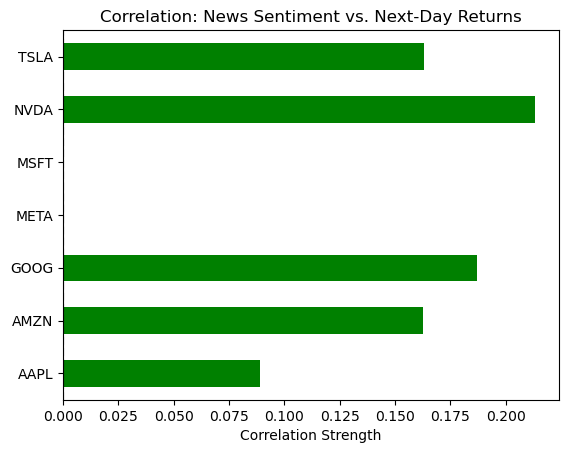

In [11]:
import matplotlib.pyplot as plt

# Plot correlation strengths
pd.Series(correlation_results).plot(
    kind='barh', 
    title='Correlation: News Sentiment vs. Next-Day Returns',
    color=[('green' if x > 0 else 'red') for x in correlation_results.values()]
)
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Correlation Strength')
plt.show()